With ResNet we decompose functions in f(x) = x + g(x), in densenet we do not restrict only to sum but more generally we concatenate outputs.

We perform a mapping from x to its values after appling an increasengly complex sequence of functions.
$$x \rightarrow [x, f_1(x), f_2([x, f_1(x)]), f_3([x, f_1(x), f_2([x, f_1(x)])]), ...] $$

Dense blocks defines how the inputs and the outputs are concatenated, while transition layers control the numer of channels

In [1]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
from torch import nn
from torch.nn import functional as F
import torch

train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))



rm: cannot remove '/content/Learning': No such file or directory
Cloning into 'Learning'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 138 (delta 74), reused 101 (delta 43), pack-reused 0
Receiving objects: 100% (138/138), 1.40 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (74/74), done.


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

60000 10000 375 94 79


In [6]:
def conv_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                         nn.LazyConv2d(num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels) -> None:
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X


def transition_block(num_channels):
    return nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                         nn.LazyConv2d(num_channels, kernel_size=1),
                         nn.AvgPool2d(kernel_size=2, stride=2))
    

class DenseNet(FFL.Classifier):

    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                             nn.LazyBatchNorm2d(), nn.ReLU(), 
                             nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def __init__(self, num_channels=64, growth_rate=32, arch=(4,4,4,4), num_classes=10) -> None:
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            # number of out channels in the previous dense block
            num_channels += num_convs * growth_rate
            # transition layer halves the number of channels
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
        self.net.add_module('last', nn.Sequential(nn.LazyBatchNorm2d(), nn.ReLU(), 
                                                  nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
                                                  nn.LazyLinear(num_classes)))




In [7]:
model, loss_f = FFL.get_model(DenseNet(), (1, 1, 96, 96))

X output shape:	 torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
Sequential output shape:	 torch.Size([1, 10])

Number of parameters: 758226


In [8]:
train_loss, val_loss, acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.01, epochs=10)

Epoch: 0, loss = 0.779574, v_loss = 0.770953, accuracy = 0.729628
Epoch: 1, loss = 0.43861, v_loss = 0.545999, accuracy = 0.802116
Epoch: 2, loss = 0.357488, v_loss = 0.547821, accuracy = 0.80093
Epoch: 3, loss = 0.312997, v_loss = 0.356947, accuracy = 0.861946
Epoch: 4, loss = 0.282969, v_loss = 0.521211, accuracy = 0.803501
Epoch: 5, loss = 0.259184, v_loss = 0.427659, accuracy = 0.83129
Epoch: 6, loss = 0.239751, v_loss = 0.427656, accuracy = 0.832971
Epoch: 7, loss = 0.222463, v_loss = 0.369435, accuracy = 0.850475
Epoch: 8, loss = 0.207484, v_loss = 0.386923, accuracy = 0.840684
Epoch: 9, loss = 0.193037, v_loss = 0.397268, accuracy = 0.837421


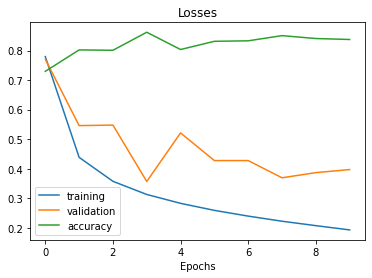

prediction comparison:

 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False, False, False, False,  True,  True,  True,
        False,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  Tr

In [9]:
FFL.after_training_plots(train_loss, val_loss, acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/DenseNet_trained.pt")
#model.load_state_dict(FFL.torch.load("/content/Learning/DenseNet_trained.pt"))